This cell below tells Jupyter to render plots on the page (not pop-up).

In [42]:
%matplotlib inline

Import all necessary libraries.

In [43]:
#standard library imports
import urllib
import json
from datetime import datetime
import os.path

#third party imports
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from obspy.imaging.beachball import beach

Define a bunch of constants that we'll use later.

In [44]:
TIMEFMT = '%Y-%m-%dT%H:%M:%S'
QUERY_TEMPLATE = 'http://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime=START&endtime=END&producttype=losspager&minmagnitude=MAG'

Modify these start/end times as desired.

In [45]:
MINMAG = 7.0
start_time = datetime(2010,9,1).strftime(TIMEFMT)
end_time = datetime.utcnow().strftime(TIMEFMT)

In [46]:
#modify the QUERY_TEMPLATE variable to use the string representing desired start time
query = QUERY_TEMPLATE.replace('START',start_time)
#make sure you modify the new query variable the second time with end time
query = query.replace('END',end_time)
#set the minimum magnitude in the query
query = query.replace('MAG',str(MINMAG))

What does this query string look like?  You can cut and paste this into your browser to see what the GeoJSON output looks like.

In [47]:
query

'http://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime=2010-09-01T00:00:00&endtime=2017-04-14T21:33:44&producttype=losspager&minmagnitude=7.0'

Open the URL, read the data from it (converting from bytes to ASCII), and then parse that string into a dictionary using the json module.

In [48]:
fh = urllib.request.urlopen(query)
data = fh.read().decode('utf-8')
fh.close()
jdict = json.loads(data)

Loop over the features (events) in the dictionary, and grab the epicenter and alert level for each one, store those ultimately in numpy arrays.

In [49]:
lats = []
lons = []
strikes = []
dips = []
rakes = []
for event in jdict['features']:
    lon,lat,depth = event['geometry']['coordinates']
    detail = event['properties']['detail']
    fh = urllib.request.urlopen(detail)
    data = fh.read().decode('utf-8')
    fh.close()
    jdict2 = json.loads(data)
    strike = float(jdict2['properties']['products']['moment-tensor'][0]['properties']['nodal-plane-1-strike'])
    dip = float(jdict2['properties']['products']['moment-tensor'][0]['properties']['nodal-plane-1-dip'])
    rake = float(jdict2['properties']['products']['moment-tensor'][0]['properties']['nodal-plane-1-rake'])
    strikes.append(strike)
    dips.append(dip)
    rakes.append(rake)
    lats.append(lat)
    lons.append(lon)
    
#make numpy arrays out of these lists
lats = np.array(lats)
lons = np.array(lons)
strikes = np.array(strikes)
dips = np.array(dips)
rakes = np.array(rakes)

Make a Robinson plot of the globe, using the default background image from Cartopy.  Then draw the events with their alert color, greens on the bottom, reds on the top.

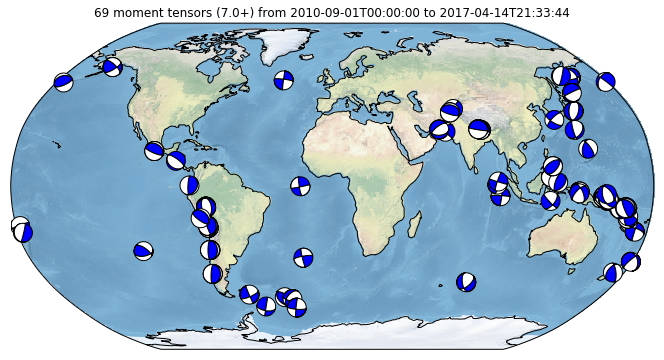

In [51]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.Robinson())

# make the map global rather than have it zoom in to
# the extents of any plotted data
ax.set_global()

ax.stock_img()
ax.coastlines()

geocrs = ccrs.PlateCarree()

for i in range(0,len(lats)):
    lat = lats[i]
    lon = lons[i]
    x,y = ax.projection.transform_point(lon,lat,geocrs)
    strike = strikes[i]
    dip = dips[i]
    rake = rakes[i]
    b = beach((strike,dip,rake), xy=(x,y), width=1e6, linewidth=1)
    b.set_zorder(100)
    ax.add_collection(b)



tstr = "{:,} moment tensors ({}+) from {} to {}".format(len(lons),MINMAG,start_time,end_time)
th=plt.title(tstr)